In [1]:
import os 
import asyncio
import shutil
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI


load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")

llm = ChatGroq(model="deepseek-r1-distill-llama-70b", max_tokens=2000, temperature=0)
llm2 = ChatOpenAI(model="gpt-4o", temperature=0,max_tokens=2000)

In [2]:
from typing import Optional, TypedDict, List
from pydantic import BaseModel, Field
from langchain_google_genai import GoogleGenerativeAIEmbeddings


embedding_model=GoogleGenerativeAIEmbeddings(model="models/embedding-001")

from langchain.schema import Document
from langchain.vectorstores import Chroma

In [3]:

vectorstore = Chroma(
    collection_name="resume_collection",
    embedding_function=embedding_model,
    persist_directory="./chromaDB"
    )


/var/folders/d_/rqsk7t093dlg0nzx8rc5n4fh0000gn/T/ipykernel_40703/2185028648.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [4]:
class email(BaseModel):
    ar_requestor: str
    recruiter : str

In [5]:
class State(TypedDict):
    resumes_dir_path: str
    jd: str
    text_resumes: List[str]  # List of text representations of resumes
    matched_resumes: List  # List of Document objects from vector store
    ranked_resumes: List  # List of Document objects ranked by relevance
    no_match: bool
    emails: Optional[email]  # Made optional and fixed typo

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage


In [7]:
os.environ["LLAMA_CLOUD_API_KEY"] = os.getenv("LLAMA_CLOUD_API_KEY")

In [8]:
from llama_cloud_services import LlamaExtract
from llama_cloud_services.extract import SourceText



extractor = LlamaExtract()

class Resume(BaseModel):
    name: str = Field(description="Full name of candidate")
    email: str = Field(description="Email address")
    skills: list[str] = Field(description="Technical skills and technologies")
    work_experience: list[str] = Field(description="Work experience details")
    education: str = Field(description="Educational background")
    projects: list[str] = Field(description="Projects worked on")


class RankedResumes(BaseModel):
    ranked_resumes: List[Resume] = Field(description="List of resumes ranked by relevance to the job description")


In [9]:
class RankedResumes(BaseModel):
    ranked_resumes: List[Resume] = Field(description="List of resumes ranked by relevance to the job description")


str_llm = llm.with_structured_output(RankedResumes)
str_llm2 = llm2.with_structured_output(RankedResumes)

In [11]:


agent = extractor.create_agent(name="resume-parser56", data_schema=Resume)
agent2 = extractor.create_agent(name="ranked_resumes100", data_schema=RankedResumes)


In [12]:
def resume_to_text(resume):
    text = f"{resume['name']} is a skilled professional.\n"
    text += f"Email: {resume['email']}\n"
    text += f"Skills: {', '.join(resume['skills'])}\n"
    
    text += "\nWork Experience:\n"
    for exp in resume['work_experience']:
        text += f"- {exp}\n"

    text += f"\nEducation: {resume['education']}\n"

    text += "\nProjects:\n"
    for proj in resume['projects']:
        text += f"- {proj}\n"

    return text.strip()

## Extracting And Storing Resumes in VectorStore

In [13]:
async def extract_and_store_resumes(state: State):
    "Extract the text from resumes and store them in vectorstore"
    resumes_dir_path = state["resumes_dir_path"]
    pdf_files = []
    for file in os.listdir(resumes_dir_path):
        if file.endswith(".pdf"):
            pdf_files.append(os.path.join(resumes_dir_path, file))

    jobs = await agent.queue_extraction(pdf_files)
    print(f"Queued {len(jobs)} extraction jobs")
    
    # Wait for all jobs to complete
    results = []
    for job in jobs:
        # Keep checking until the job is complete
        while True:
            result = agent.get_extraction_run_for_job(job.id)
            status = result.status.value
            
            if status in ['COMPLETED', 'SUCCESS']:  # Handle both possible success statuses
                results.append(result)
                print(f"Job {job.id} completed successfully")
                break
            elif status == 'FAILED':
                print(f"Job {job.id} failed: {result.error}")
                break
            else:
                print(f"Job {job.id} status: {status}, waiting...")
                await asyncio.sleep(2)  # Wait 2 seconds before checking again
    
    print(f"All jobs completed. Processing {len(results)} results.")
    resumes = []

    for result in results:
        if result.data:  # Check if data exists
            resume_info = {
                'name': result.data["name"],
                'email': result.data["email"],
                'skills': result.data["skills"],
                'work_experience': result.data["work_experience"],
                'education': result.data["education"],
                'projects': result.data["projects"]
            }
            resumes.append(resume_info)
            
        else:
            print(f"Warning: No data found for job {result.job_id}")
    
    text_resumes = [resume_to_text(resume) for resume in resumes]



    docs = []

    for resume in resumes:
        text = resume_to_text(resume)
        doc = Document(
            page_content=text,
            metadata={
                "name": resume["name"],
                "email": resume["email"],
                "skills": ', '.join([s.lower().strip() for s in resume["skills"]])
            }
        )
        docs.append(doc)
    vectorstore.add_documents(docs)
    vectorstore.persist()
    
    return {"text_resumes": text_resumes}

## Comparison Agent

In [14]:
async def comparison_agent(state: State):
    '''This node will compare the JD with resume and give the matching resumes'''

    jd_text = state["jd"]


    matched_resumes = vectorstore.similarity_search(jd_text, k=3)

    return {"matched_resumes": matched_resumes}





## Ranking Agent 

In [15]:
async def ranking_agent(state: State):
    '''This node will rank the matched resumes based on their relevance to the JD'''

    matched_resumes = state["matched_resumes"]
    
    if not matched_resumes:
        return {"ranked_resumes": [], "no_match": True}
    
    # Convert Document objects to a simpler format for ranking
    resume_texts = []
    for doc in matched_resumes:
        resume_info = {
            "name": doc.metadata.get("name", "Unknown"),
            "email": doc.metadata.get("email", "Unknown"),
            "content": doc.page_content,
            "skills": doc.metadata.get("skills", "")
        }
        resume_texts.append(resume_info)
    
    # Create a simpler prompt for ranking without structured output
    ranking_prompt = f"""
    Job Description: {state['jd']}
    
    Please rank the following resumes from most relevant (1) to least relevant based on the job description.
    Return only the ranking as a numbered list with name and email.
    Return all the resumes in the order of their relevance to the job description.
    You must provide me the name, email, skills and work experience of each resume in the ranking list
    
    Resumes to rank:
    """
    
    for i, resume in enumerate(resume_texts, 1):
        ranking_prompt += f"\n{i}. Name: {resume['name']}\n   Email: {resume['email']}\n   Skills: {resume['skills']}\n   Content: {resume['content'][:500]}...\n"
    
    print("calling LLM")
    # Use regular LLM invoke instead of structured output
    ranking_response = llm.invoke([
        SystemMessage(content="You are a recruitment expert. Rank the resumes based on their relevance to the job description."),
        HumanMessage(content=ranking_prompt)
    ])

    print(f"Ranking response: {ranking_response.content}")
    
    # For now, return the original matched resumes in order (since vector store already does similarity matching)
    # The LLM response can be used for additional insights
    ranked_resumes = agent2.extract(SourceText(text_content=ranking_response.content))
    
    return {"ranked_resumes": ranked_resumes.data["ranked_resumes"], "no_match": False}

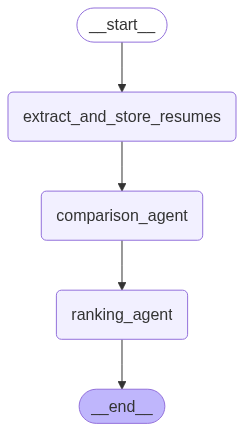

In [16]:
from langgraph.graph import StateGraph, END, START
from IPython.display import Image, display

flow = StateGraph(State)

flow.add_node("extract_and_store_resumes", extract_and_store_resumes)
flow.add_node("comparison_agent", comparison_agent)
flow.add_node("ranking_agent", ranking_agent)

flow.add_edge(START, "extract_and_store_resumes")
flow.add_edge("extract_and_store_resumes", "comparison_agent")
flow.add_edge("comparison_agent", "ranking_agent")
flow.add_edge("ranking_agent", END)

chain = flow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))


In [17]:
res = await chain.ainvoke({"resumes_dir_path": "/Users/yashpatil/Developer/AI/ResumeJDMatcher/data", "jd": """Seeking a versatile HR Generalist to manage the full employee lifecycle, from recruitment and onboarding to employee relations and policy implementation.
"""})

I0000 00:00:1753632016.222967 3421331 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Creating extraction jobs: 100%|██████████| 7/7 [00:18<00:00,  2.59s/it]


Queued 7 extraction jobs
Job 9381e628-46fb-4a02-999c-8ba404506b3d completed successfully
Job 8416c0fd-f6b5-47db-95d3-cf8528e4e14d completed successfully
Job 7af46822-488b-4f41-967f-4c376f2b552f status: PENDING, waiting...
Job 7af46822-488b-4f41-967f-4c376f2b552f status: PENDING, waiting...
Job 7af46822-488b-4f41-967f-4c376f2b552f completed successfully
Job 36ad28b0-9fcd-4423-be89-08f6eb2ad4e8 completed successfully
Job e0053f04-5237-4264-835b-1869e4127489 completed successfully
Job 6a6b88d7-c488-4f9e-b52d-036743b69a98 completed successfully
Job f424573c-2372-4d66-ac71-40c2f163bcc6 completed successfully
All jobs completed. Processing 7 results.


/var/folders/d_/rqsk7t093dlg0nzx8rc5n4fh0000gn/T/ipykernel_40703/475922639.py:67: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


calling LLM
Ranking response: <think>
Okay, so I need to rank these three resumes based on how well they fit the job description for an HR Generalist position. The job is looking for someone who can handle the full employee lifecycle, including recruitment, onboarding, employee relations, and policy implementation. 

First, I'll look at each resume one by one. 

Starting with Bethany Aster. Her skills include PHR certification, which is relevant because it's a recognized HR credential. She also has experience with ATS (Applicant Tracking Systems) like Workday and Jobvite, which are important for recruitment. Her skills in compensation, benefits, payroll, and performance management are all key areas for an HR Generalist. Looking at her work experience, she's been an HR Generalist since 2017, which is a good sign. She's handled recruitment programs and improved hiring practices, which directly relates to the job description. So, she seems like a strong candidate.

Next, Kieran Gallagher.

Extracting files: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


In [18]:
res

{'resumes_dir_path': '/Users/yashpatil/Developer/AI/ResumeJDMatcher/data',
 'jd': 'Seeking a versatile HR Generalist to manage the full employee lifecycle, from recruitment and onboarding to employee relations and policy implementation.\n',
 'text_resumes': ['Yash Patil is a skilled professional.\nEmail: Yashstudy02@gmail.com\nSkills: JavaScript (ES6+), Node.js, Python, TypeScript, React, Express, MongoDB, Next.js, streamlit, Figma, Canva, Premier Pro, AWS, Netlify, Vercel, RESTful API, Git, Postman, Npm, Stripe, Firebase, Axios, React Router, Agile Experience, Responsive & Mobile-First Design, CI/CD Pipeline using Github\n\nWork Experience:\n- UX Designer and Web Developer Intern at Techwarium from Aug 2024 to Oct 2024.\n- UX Designer and Web Developer Intern at Techwarium from Dec 2024 to Feb 2024.\n\nEducation: B.E. (CSE), AITR, RGPV Bhopal, 2025, 7.1 CGPA; 12th, Shree Vaishnav Academy, CBSE, 2020, 82%; 10th, Shree Vaishnav Academy, CBSE, 2018, 82%\n\nProjects:\n- SpaceWeather: Deve

In [19]:
res["ranked_resumes"]

[{'name': 'Bethany Aster',
  'email': 'b.aster@email.com',
  'skills': ['PHR Certification',
   'ATS (Workday, Jobvite)',
   'Compensation & Benefits',
   'Payroll',
   'Performance Management'],
  'work_experience': ['HR Generalist with experience in recruitment, onboarding, and employee relations.'],
  'education': '',
  'projects': []},
 {'name': 'Catherine Stark',
  'email': 'catherinestark@email.com',
  'skills': ['AWS',
   'Python',
   'Java',
   'Ruby',
   'Bash',
   'Kubernetes',
   'Terraform',
   'Cloudformation',
   'Jenkins'],
  'work_experience': ['AWS DevOps Engineer with experience in automation and process management, which could have indirect applications in HR systems.'],
  'education': '',
  'projects': []},
 {'name': 'Kieran Gallagher',
  'email': 'k.gallagher@email.com',
  'skills': ['Azure Pipelines',
   'LAMP stack',
   'MySQL',
   'Nagios',
   'GitLab',
   'RESTful APIs in Django',
   'KVM/VZ Virtualization',
   'Terraform',
   'Ansible',
   'Docker',
   'Zend F

In [ ]:
res["matched_resumes"]